In [1]:
import pandas as pd
import folium
from geopy import distance
import matplotlib.pyplot as plt
import seaborn as sns
import descartes
import geopandas as gpd
import libpysal
from shapely.geometry import Point, Polygon
from libpysal import weights, examples
from libpysal.cg import voronoi_frames
from contextily import add_basemap
import networkx as nx
import numpy as np
import logging
import requests_cache
import requests
import json

In [2]:
df = pd.read_csv(r"C:\Users\marco\Downloads\Electric_Vehicle_Charging_Stations_in_New_York (1).csv")

In [3]:
df['Year'] = df['Open Date'].str[6:]
df = df.fillna(value=0)
df = df.drop(['Fuel Type Code', 'Intersection Directions','Station Phone','Status Code','Owner Type Code',
         'Federal Agency ID','Federal Agency Name','Cards Accepted',
         'EV Network Web','ZIP','Groups With Access Code','Expected Date','Access Days Time',
         'Geocode Status','Updated At','Plus4','Date Last Confirmed',"EV Other Info","Open Date"], axis=1)

In [4]:
df.tail(50)

,Station Name,Street Address,City,State,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV_Network,Latitude,Longitude,ID,EV Connector Types,Year
3209,"Montauk, NY - Tesla Supercharger",70 South Euclid Avenue,Montauk,NY,0.0,0.0,8.0,Tesla,41.036062,-71.943509,170431,TESLA,2020
3210,Ultralife Corporation,2000 Technology Parkway,"Newark,",NY,0.0,2.0,0.0,EV Connect,43.026445,-77.091189,154908,J1772,2019
3211,Boiler ER Lot,2157 Main St Buffalo,Buffalo,NY,0.0,2.0,0.0,EV Connect,42.927789,-78.847434,202631,J1772,2021
3212,LPCL STATION1,30 Lake Placid Club Way,Lake Placid,NY,0.0,2.0,0.0,ChargePoint Network,44.283206,-73.979572,123468,J1772,2019
3213,Icon Parking 560 Third Ave - Tesla Destination,560 3rd Ave,New York,NY,0.0,3.0,0.0,Tesla Destination,40.747962,-73.976569,115162,J1772 TESLA,2016
3214,Walmart 1949 Fredonia,10401 Bennett Road,Fredonia,NY,0.0,0.0,4.0,Electrify America,42.453790,-79.311180,168359,CHADEMO J1772COMBO,2020
3215,Hilton Garden Inn Watertown - Tesla Destination,1290 Arsenal St,Watertown,NY,0.0,2.0,0.0,Tesla Destination,43.979571,-75.946973,115246,J1772 TESLA,2016
3216,West Genesee Athletic Club,6415 Pottery Rd,Warens,NY,0.0,2.0,0.0,LIVINGSTON,43.080330,-76.284060,223135,J1772,2021
3217,854ELLICOTT 134 HIGH ST 9,134 High St,Buffalo,NY,0.0,2.0,0.0,ChargePoint Network,42.901006,-78.863905,181848,J1772,2021
3218,"CDTA CDTA #2, SOUTH",122 Industrial Park Rd,Albany,NY,0.0,2.0,0.0,ChargePoint Network,42.679626,-73.779698,186566,J1772,2021


In [5]:
città_rilevanti = ['New York',"Bronx","Brooklyn","Queens","Staten Island",
         "Manhattan","Borough Park","Washington Heights","New York City",
        "Astoria","Jamaica","JAMAICA","Jackson Heights",]
esclusione = ["Geneva on the Lake Resort", "ABELENORTHSIDE STATION 1","Buy Low Flooring / Queen of Harts Pizza"]
Network = ["Tesla","LIVINGSTON","EV Connect"]

In [6]:
# occurrences = df['EV_Network'].value_counts()
# print(occurrences)

I 4 maggiori Network di ricarica appartengono a Tesla, Livingstone e EV Connect, e quelli che non sono compresi in nessun network specifico. Con questi 4 otteniamo circa il 42% della rete. 

Vengono eliminate le colonne che non presentano dati utili all'analisi o che presentano dei NaN in ogni osservazione.

In [7]:
df.index.names = ['Index']
df = df.fillna(value=0)
df.shape

(3259, 13)

Il dataset presenta 3261 osservazioni, solo relative allo stato di New York. 

In [8]:
df =df.reset_index(drop=True)

In [9]:
df

,Station Name,Street Address,City,State,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV_Network,Latitude,Longitude,ID,EV Connector Types,Year
0,St. George Courthouse,54 Central Ave,Staten Island,NY,0.0,5.0,0.0,EV Connect,40.639469,-74.076912,65296,J1772,2016
1,RRH RIEDMAN CAMP10,100 Kings Hwy S,Rochester,NY,0.0,2.0,0.0,ChargePoint Network,43.201826,-77.574561,121386,J1772,2019
2,Avon,74 Genesee Street,Avon,NY,0.0,2.0,0.0,EV Connect,42.910944,-77.746320,123132,J1772,2019
3,SKIDMORE SUSSMAN,Lower Scribner Village Rd,Saratoga Springs,NY,0.0,2.0,0.0,ChargePoint Network,43.098653,-73.789220,123552,J1772,2019
4,WARRENCOUNTY DPW 2,1344 U.S. 9,Lake George,NY,0.0,2.0,0.0,ChargePoint Network,43.359015,-73.701099,150258,J1772,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,1285 MAIN 1285 MAIN (1),1285 Main St,Buffalo,NY,0.0,2.0,0.0,ChargePoint Network,42.908237,-78.866359,154372,J1772,2020
3255,532 W 122nd St,532 W 122nd St,New York,NY,0.0,4.0,0.0,EV Connect,40.811446,-73.960477,168414,J1772,2020
3256,BNL NSLS-II LOB-4,Loop Rd,Upton,NY,0.0,2.0,0.0,Non-Networked,40.862723,-72.872473,184440,J1772,2021
3257,TANNERSVILLE MUNICIPAL LOT,20 Tompkins St,Tannersville,NY,0.0,2.0,0.0,ChargePoint Network,42.195133,-74.132420,152438,J1772,2020


In [10]:
# NYC_df["Next Latitude"],NYC_df["Next Longitude"] = "",""

In [11]:
# for i in range(0, (NYC_df.shape[0]-1)):
#          NYC_df["Next Latitude"][i] = NYC_df["Latitude"][i+1]
#          NYC_df["Next Longitude"][i] = NYC_df["Longitude"][i+1]

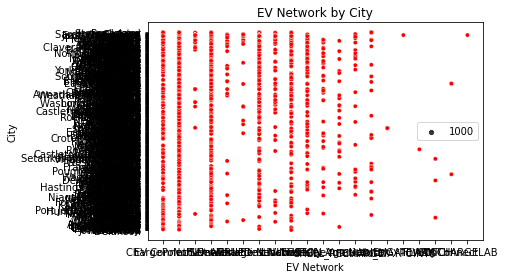

In [12]:
sns.scatterplot(x='EV_Network', y='City', data=df, size=1000, color='red')
plt.title("EV Network by City")
plt.xlabel("EV Network")
plt.ylabel("City")
plt.show()

Plot della mappa

In [13]:
location = df[["Latitude", "Longitude", "Station Name","EV_Network","ID"]]

In [14]:
# Calculate the center of the map based on the mean of Latitude and Longitude values
mean_latitude = location['Latitude'].mean()
mean_longitude = location['Longitude'].mean()

In [15]:
map = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=0.5, control_scale=True)
location.apply(lambda x: folium.Marker([x["Latitude"], x["Longitude"]], popup=x["Station Name"]).add_to(map), axis=1)

0       <folium.map.Marker object at 0x000001ADC6958670>
1       <folium.map.Marker object at 0x000001ADC6958100>
2       <folium.map.Marker object at 0x000001ADC695BB80>
3       <folium.map.Marker object at 0x000001ADC695BF70>
4       <folium.map.Marker object at 0x000001ADC695B7C0>
                              ...                       
3254    <folium.map.Marker object at 0x000001ADC6946050>
3255    <folium.map.Marker object at 0x000001ADC6945F30>
3256    <folium.map.Marker object at 0x000001ADC6945E10>
3257    <folium.map.Marker object at 0x000001ADC6945CF0>
3258    <folium.map.Marker object at 0x000001ADC6945BD0>
Length: 3259, dtype: object

In [ ]:
map

Calcolo distanza e tempo di guida da una colonnina alla successiva

In [16]:
df["Distance"],df["Duration"]="",""

Calcolo della distanza tramite Open Street Map

In [17]:
API_key = '96dd7cb32a8d43a1b8c78d219b21d381'
url = 'http://router.project-osrm.org/route/v1/driving/'

In [18]:
def getDistances(row):
    o1 = str(row['Longitude']) +',' + str(row['Latitude'])
    o2 = str(row['Next Longitude']) + ',' + str(row['Next Latitude']) 
    x = o1 + ';' + o2
    
    response = requests.get(url+x)
    data = json.loads(response.content)
    
    if response.status_code == 200:
        return data['routes'][0]['distance']/1000 #in km
    else:
        return 0

In [19]:
def getDuration(row):
    o1 = str(row['Longitude']) +',' + str(row['Latitude'])
    o2 = str(row['Next Longitude']) + ',' + str(row['Next Latitude']) 
    x = o1 + ';' + o2
    
    response = requests.get(url+x)
    data = json.loads(response.content)
    
    if response.status_code == 200:
        return data['routes'][0]['duration']/60 #in min
    else:
        return 0

In questo modo otterremo la distanza (in miglia) tra una colonnina e la successiva

In [20]:
df = df.sort_values(by=["City",'Latitude', 'Longitude'])

In [21]:
df["Next Latitude"] = df["Latitude"].shift(-1)
df["Next Longitude"] = df["Longitude"].shift(-1)

Divido il dataset in 4 (uno per ogni network) in modo da poter confrontare i pattern di posizionamento.

In [22]:
df = df.reset_index(drop=True)

In [23]:
df.shape

(3259, 17)

In [24]:
df["Distance"]  = df.apply(getDistances, axis = 1)
df["Duration"]  = df.apply(getDuration, axis = 1)

In [25]:
quantiles = df["Distance"].quantile([0.25, 0.75])
media = df["Distance"].mean()
minimum = df["Distance"].min()
maximum = df["Distance"].max()

print("\nDistance")
print("\nQuantili a 0.25 e 0.75:")
print(quantiles)
print("Media :" + str(media))
print("Minimo :"+str(minimum))
print("Massimo :"+ str(maximum))

quantiles_d= df["Duration"].quantile([0.25, 0.75])
media_d = df["Duration"].mean()
minimum_d = df["Duration"].min()
maximum_d = df["Duration"].max()
print("\nDuration")
print("\nQuantili a 0.25 e 0.75:")
print(quantiles_d)
print("Media :" + str(media_d))
print("Minimo :"+str(minimum_d))
print("Massimo :"+ str(maximum_d))


Distance

Quantili a 0.25 e 0.75:
0.25    0.20245
0.75    5.95315
Name: Distance, dtype: float64
Media :53.51008815587603
Minimo :0.0
Massimo :757.3858

Duration

Quantili a 0.25 e 0.75:
0.25    0.685000
0.75    8.963333
Name: Duration, dtype: float64
Media :43.96906157307968
Minimo :0.0
Massimo :595.1800000000001


In [26]:
def create_and_draw_graph(df, color, title):
    G = nx.Graph()
    for index, row in df.iterrows():
        G.add_node(row["ID"], pos=(row["Longitude"], row["Latitude"]))
        if index > 0:
            G.add_edge(df.iloc[index-1]["ID"], row["ID"])
    nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=False, node_size=5, node_color=color)
    plt.title(title)

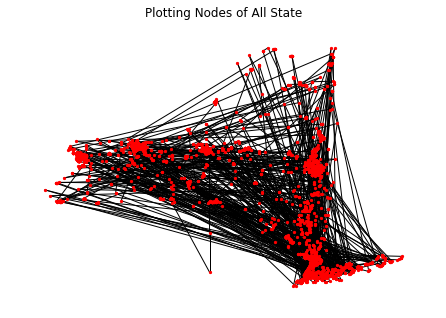

In [27]:
data = [(df, "red", "Plotting Nodes of All State"),]

for df, color, title in data:
    create_and_draw_graph(df, color, title)

plt.savefig("./graph_state_general.png", dpi=300)
plt.show()

In [30]:
df["EV_Network"].value_counts()

ChargePoint Network    1619
Tesla Destination       469
Non-Networked           273
LIVINGSTON              256
EV Connect              241
Blink Network            96
Tesla                    80
FLO                      47
Electrify America        38
Volta                    31
AMPUP                    30
SHELL_RECHARGE           24
eVgo Network             23
SemaCharge Network       19
RIVIAN_WAYPOINTS          4
SWTCH                     3
OpConnect                 3
EVGATEWAY                 1
CHARGELAB                 1
FLASH                     1
Name: EV_Network, dtype: int64

In [31]:
values=["Tesla","Tesla Destination"]
tesla_df = df[df.EV_Network.isin(values)]
evc_df = df[df['EV_Network'] =="EV Connect"]
l_df = df[df['EV_Network'] =="LIVINGSTON"]

In [32]:
tesla_df = tesla_df.sort_values(by=["City",'Latitude', 'Longitude'])
evc_df = evc_df.sort_values(by=["City",'Latitude', 'Longitude'])
l_df = l_df.sort_values(by=["City",'Latitude', 'Longitude'])

In [33]:
tesla_df["Next Latitude"] = tesla_df["Latitude"].shift(-1)
tesla_df["Next Longitude"] = tesla_df["Longitude"].shift(-1)
evc_df["Next Latitude"] = evc_df["Latitude"].shift(-1)
evc_df["Next Longitude"] = evc_df["Longitude"].shift(-1)
l_df["Next Latitude"] = l_df["Latitude"].shift(-1)
l_df["Next Longitude"] = l_df["Longitude"].shift(-1)

In [34]:
tesla_df =tesla_df.reset_index(drop=True)
evc_df =evc_df.reset_index(drop=True)
l_df =l_df.reset_index(drop=True)

In [35]:
tesla_df["Distance"]  = tesla_df.apply(getDistances, axis = 1)
tesla_df["Duration"]  = tesla_df.apply(getDuration, axis = 1)
evc_df["Distance"]  = evc_df.apply(getDistances, axis = 1)
evc_df["Duration"]  = evc_df.apply(getDuration, axis = 1)
l_df["Distance"]  = l_df.apply(getDistances, axis = 1)
l_df["Duration"]  = l_df.apply(getDuration, axis = 1)

Media di betweenness centrality per Tesla: [0.0]
Media di closeness centrality per Tesla: [0.028440275241521117]

Media di betweenness centrality per Livingston: [0.0]
Media di closeness centrality per Livingston: [0.09158438784549255]

Media di betweenness centrality per EV Connect: [0.0]
Media di closeness centrality per EV Connect: [0.12490409216396446]



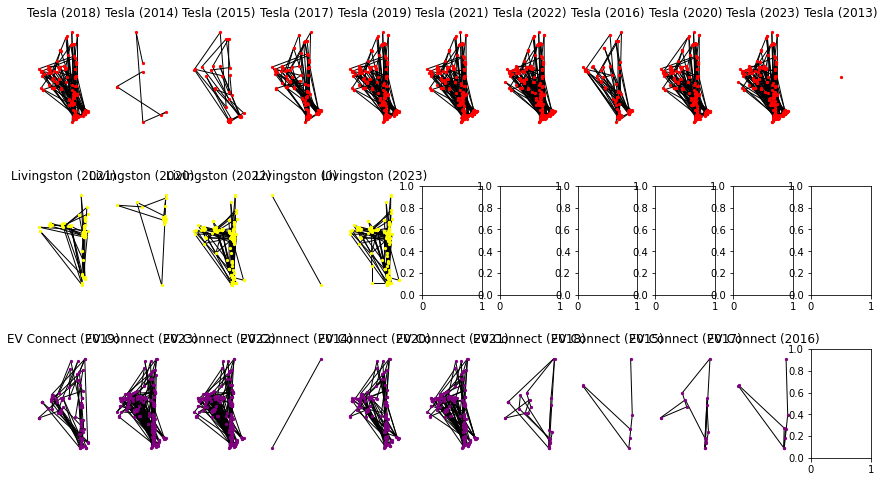

In [37]:
fig, axs = plt.subplots(3, tesla_df["Year"].nunique(), figsize=(15, 8))
data = [(tesla_df, "red", "Tesla"), (l_df, "yellow", "Livingston"), (evc_df, "purple", "EV Connect")]
betweenness_centralities = []
closeness_centralities = []

for i, (df, color, title) in enumerate(data):
    years = df["Year"].unique()
    for j, year in enumerate(years):
        G = nx.Graph()
        year=int(year)
        year_df = df[df["Year"].astype(int) <= year].reset_index(drop=True)
        for k in range(year_df.shape[0]):
            pos = (year_df.iloc[k]["Longitude"], year_df.iloc[k]["Latitude"])
            G.add_node(year_df.iloc[k]["ID"], pos=pos)
            if k > 0:
                G.add_edge(year_df.iloc[k-1]["ID"], year_df.iloc[k]["ID"])
        nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=False, node_size=5, node_color=color, ax=axs[i, j])
        axs[i, j].set_title("{} ({})".format(title, year))
#calcolo le misure di centralità
        betweenness = nx.betweenness_centrality(G)
        closeness = nx.closeness_centrality(G)
        
#print(betweenness)
        betweenness_centralities.append(list(betweenness.values()))
        closeness_centralities.append(list(closeness.values()))

#calcolo la media di betweenness e closeness per ogni dataframe
    avg_betweenness = [sum(x)/len(betweenness_centralities) for x in zip(*betweenness_centralities)]
    avg_closeness = [sum(x)/len(closeness_centralities) for x in zip(*closeness_centralities)]

    print("Media di betweenness centrality per {}: {}".format(title, avg_betweenness))
    print("Media di closeness centrality per {}: {}\n".format(title, avg_closeness))

# plt.tight_layout()
fig.subplots_adjust(wspace=0.3,hspace=0.5)
plt.savefig("./Graph_State_Years.png", dpi=1000)
plt.show()

Il grafo risultante per l'intero stato si presenta molto confuso e poco significativo. L'unica informazione che si può ottenere è la maggiore concentrazione nelle aree urbane a densità maggiore, come si poteva facilmente prevedere: ad esempio le città di New York e Buffalo